In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql import functions

def parseInput(line):
    fields = line.split('|')
    return Row(user_id = int(fields[0]), age = int(fields[1]), gender = fields[2], occupation = fields[3], zip = fields[4])

if __name__ == "__main__":
    # Create a SparkSession
    spark = SparkSession.builder.appName("CassandraIntegration").config("spark.cassandra.connection.host","127.0.0.1").getOrCreate()
    # Get the raw data
    lines = spark.sparkContext.textFile("hdfs:///user/maria_dev/ml-100k/u.user")
    # Convert it to a RDD of Row objects with (userID, age, gender, occupation, zip)
    users = lines.map(parseInput)
    # Convert that to a DataFrame
    usersDataset = spark.createDataFrame(users)

    # Write it into Cassandra
    usersDataset.write\
        .format("org.apache.spark.sql.cassandra")\
        .mode('append')\
        .options(table="users", keyspace="movielens")\
        .save()

    # Read it back from Cassandra into a new Dataframe
    readUsers = spark.read\
        .format("org.apache.spark.sql.cassandra")\
        .options(table="users", keyspace="movielens")\
        .load()

    readUsers.createOrReplaceTempView("users")

    sqlDF1 = spark.sql("SELECT * FROM users WHERE age < 20")
    print("Users who are younger than 20 years old:")
    sqlDF1.show(10)

    sqlDF2 = spark.sql("SELECT * FROM users WHERE age >= 30 AND age <=40 AND occupation = 'scientist'")
    print("Users who are scientists between 30 and 40 years old:")
    sqlDF2.show(10)

    # Stop the session
    spark.stop()


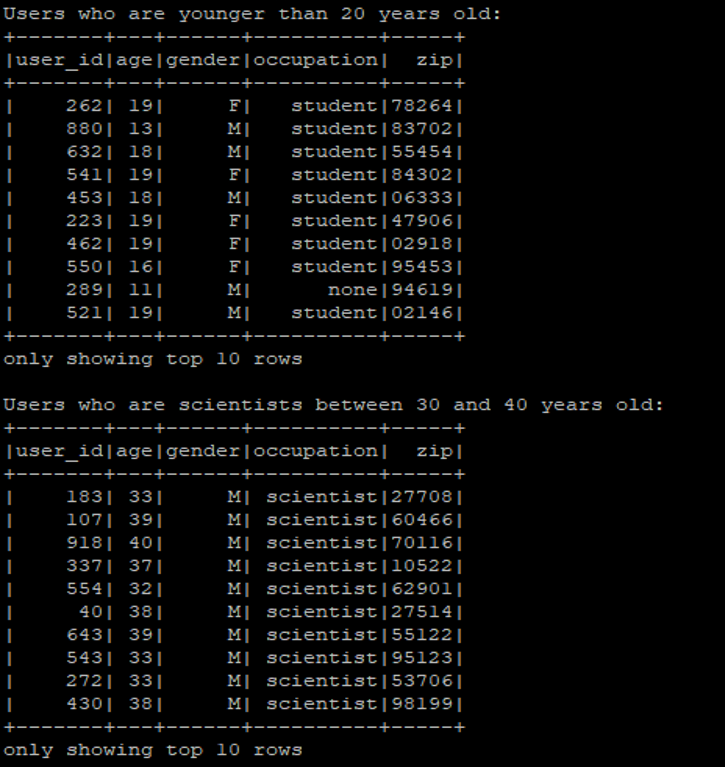